*Dropout Rate Study*

We vary the dropout rates as 0.2 and 0.4 in this notebook. We also compare the results obtained here with the results obtained in the other notebook with dropout rate 0.5 and 0.6. 

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from tqdm import tqdm

from gensim.models import KeyedVectors


In [2]:
TRAIN_PATH = '/kaggle/input/bias-of-us-news-media-houses/Train.xlsx'

def clean_text(text: str) -> str:
    """Clean the input text by removing URLs, 'RT', special characters, and extra whitespace."""
    text = re.sub(r"http\S+", " ", text)  # remove URLs
    text = re.sub(r"RT ", " ", text)       # remove 'RT'
    text = re.sub(r"[^a-zA-Z\'\.\,\d\s]", " ", text)  # remove unwanted characters
    text = re.sub(r'\t', ' ', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def load_and_preprocess_data(path: str) -> pd.DataFrame:
    df = pd.read_excel(path, engine='openpyxl')
    for col in ['content_original', 'title']:
        # Use only the first section if split by the delimiter
        df[col] = df[col].str.split(' \n\n---\n\n').str[0]
        # Replace dashes and punctuation, then lower the text
        df[col] = (df[col]
                   .str.replace('-', ' ')
                   .str.replace('[^\w\s]', '', regex=True)
                   .str.replace('\n', ' ')
                   .str.lower())
        df[col] = df[col].apply(clean_text)
    return df

# Load and preview the data
df_train = load_and_preprocess_data(TRAIN_PATH)
df_train.head(2)


,Unnamed: 0,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID
0,0,immigration,National Review,2,https://www.nationalreview.com/2018/12/governm...,shutdown theater again,2018-12-12,"Kevin D. Williamson, Kyle Smith, Andrew C. Mcc...",President Trump and Senate Minority Leader Chu...,president trump and senate minority leader chu...,www.nationalreview.com,right,zl7kc7EmAyIdUMIo
1,1,culture,Yahoo! The 360,1,https://news.yahoo.com/can-the-developing-worl...,can the developing world endure the coronavirus,2020-06-30,Mike Bebernes,“ The 360 ” shows you diverse perspectives on ...,the 360 shows you diverse perspectives on the ...,www.news.yahoo.com,center,xpbjYTJYPdlw6HmJ


In [3]:
# Update the path to your Word2Vec file; for example:
word2vec_model_path = '/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin'
cached_kv_path = 'word2vec_model.kv'

if os.path.exists(cached_kv_path):
    print("Loading cached Word2Vec model...")
    w2v_model = KeyedVectors.load(cached_kv_path, mmap='r')
else:
    print("Loading Word2Vec model from binary file (this may take several minutes)...")
    w2v_model = KeyedVectors.load_word2vec_format(word2vec_model_path, binary=True)
    print("Saving cached version...")
    w2v_model.save(cached_kv_path)

# Build vocabulary mapping and embedding matrix.
# Reserve index 0 for unknown words.
UNK_TOKEN = "<unk>"
UNK_INDEX = 0
# Create vocabulary mapping, shifting indices by 1 so that index 0 is reserved for UNK.
word2vec_vocab = {word: idx + 1 for word, idx in w2v_model.key_to_index.items()}
vocab_size = len(word2vec_vocab) + 1
embedding_dim = w2v_model.vector_size  # typically 300

# Build the embedding matrix (row 0 will remain zeros for UNK)
embedding_matrix = torch.zeros(vocab_size, embedding_dim)
for word, idx in word2vec_vocab.items():
    embedding_matrix[idx] = torch.tensor(w2v_model[word])
    
print(f"Word2Vec embeddings loaded: vocab size = {vocab_size}, embedding dim = {embedding_dim}")


Loading Word2Vec model from binary file (this may take several minutes)...
Saving cached version...
Word2Vec embeddings loaded: vocab size = 3000001, embedding dim = 300


In [4]:
def basic_tokenizer(text: str) -> list:
    """Tokenize text by splitting on whitespace."""
    return text.split()

def tokenize_and_pad(text: str, max_len: int) -> torch.Tensor:
    """
    Tokenizes the input text and converts tokens to indices using the Word2Vec vocabulary.
    Unknown tokens are assigned index 0. The sequence is padded or truncated to max_len.
    """
    tokens = basic_tokenizer(text)
    indices = [word2vec_vocab.get(token, UNK_INDEX) for token in tokens]
    padded = indices[:max_len] + [0] * max(0, max_len - len(indices))
    return torch.tensor(padded)


In [5]:
class BiasDataset(Dataset):
    def __init__(self, data: pd.DataFrame, max_sentence_length: int):
        self.data = data.reset_index(drop=True)
        self.max_sentence_length = max_sentence_length

    def __len__(self) -> int:
        return len(self.data)
  
    def __getitem__(self, index: int) -> dict:
        row = self.data.iloc[index]
        body = tokenize_and_pad(row['content_original'], self.max_sentence_length)
        title = tokenize_and_pad(row['title'], self.max_sentence_length)
        # Assuming 'bias' is an integer label
        label = torch.tensor(row['bias'], dtype=torch.long)
        return {"body": body, "title": title, "labels": label}

class BiasDataModule(pl.LightningDataModule):
    def __init__(self, train_df: pd.DataFrame, val_df: pd.DataFrame, max_sentence_length: int, batch_size: int):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.max_sentence_length = max_sentence_length
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = BiasDataset(self.train_df, self.max_sentence_length)
        self.val_dataset = BiasDataset(self.val_df, self.max_sentence_length)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                          shuffle=True, num_workers=4, drop_last=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=4, drop_last=False)

# Split the dataset (e.g., 80% train, 20% validation)
train_df, val_df = train_test_split(df_train, test_size=0.2, random_state=42)
print("Train shape:", train_df.shape, "Val shape:", val_df.shape)

BATCH_SIZE = 1024
MAX_LEN = 120  # Adjust based on your text lengths
data_module = BiasDataModule(train_df, val_df, max_sentence_length=MAX_LEN, batch_size=BATCH_SIZE)
data_module.setup()


Train shape: (21272, 13) Val shape: (5318, 13)


In [6]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchmetrics

class LitBiasModel_NoMHA(pl.LightningModule):
    def __init__(self, embedding_matrix: torch.Tensor, num_classes: int,
                 embed_dim: int, hidd_dim: int, num_layers: int = 2, 
                 dropout_rate: float = 0.4, lr: float = 1e-3):
        super().__init__()
        self.save_hyperparameters(ignore=["embedding_matrix"])
        
        # Frozen embedding layer using pretrained Word2Vec embeddings
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        
        # Shared bidirectional LSTM layer with dropout
        self.bilstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidd_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate,
            bidirectional=True
        )
        
        # Classification head (feedforward network) with dropout
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.ReLU(),
            nn.Linear(hidd_dim, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout_rate),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.Dropout(dropout_rate),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
        
        self.loss_fn = nn.CrossEntropyLoss()
        self.train_acc = torchmetrics.Accuracy(num_classes=num_classes, task="multiclass")
        self.val_acc = torchmetrics.Accuracy(num_classes=num_classes, task="multiclass")
        self._train_losses = []
        self._val_losses = []
        self.train_history = {"acc": [], "loss": []}
        self.val_history = {"acc": [], "loss": []}

    def forward(self, title: torch.Tensor, body: torch.Tensor) -> torch.Tensor:
        # Obtain embeddings
        title_embed = self.embedding(title)
        body_embed = self.embedding(body)
        
        # Shared bidirectional LSTM for title and body separately
        _, (title_hidden, _) = self.bilstm(title_embed)
        _, (body_hidden, _) = self.bilstm(body_embed)
        
        # Aggregate hidden states by mean pooling over layers
        title_repr = title_hidden.permute(1, 0, 2).mean(dim=1)
        body_repr = body_hidden.permute(1, 0, 2).mean(dim=1)
        
        # Fuse the representations
        aggregated = (title_repr + body_repr) / 2
        
        logits = self.classifier(aggregated)
        return logits

    def training_step(self, batch, batch_idx):
        logits = self.forward(batch["title"], batch["body"])
        loss = self.loss_fn(logits, batch["labels"])
        self._train_losses.append(loss)
        self.train_acc.update(logits, batch["labels"])
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        logits = self.forward(batch["title"], batch["body"])
        loss = self.loss_fn(logits, batch["labels"])
        self._val_losses.append(loss)
        self.val_acc.update(logits, batch["labels"])
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        avg_loss = torch.stack(self._train_losses).mean() if self._train_losses else torch.tensor(0.0, device=self.device)
        train_acc = self.train_acc.compute()
        self.train_history["loss"].append(avg_loss.item())
        self.train_history["acc"].append(train_acc.item())
        self.log_dict({"Epoch_Train_Loss": avg_loss, "Epoch_Train_Acc": train_acc}, prog_bar=True)
        print(f"Train - Acc: {train_acc:.4f}, Loss: {avg_loss:.4f}")
        self.train_acc.reset()
        self._train_losses.clear()

    def on_validation_epoch_end(self):
        avg_loss = torch.stack(self._val_losses).mean() if self._val_losses else torch.tensor(0.0, device=self.device)
        val_acc = self.val_acc.compute()
        self.val_history["loss"].append(avg_loss.item())
        self.val_history["acc"].append(val_acc.item())
        self.log_dict({"Epoch_Val_Loss": avg_loss, "Epoch_Val_Acc": val_acc}, prog_bar=True)
        print(f"Val - Acc: {val_acc:.4f}, Loss: {avg_loss:.4f}")
        self.val_acc.reset()
        self._val_losses.clear()

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)

dropout_rates = [0.2, 0.4]  # Experiment with different dropouts





In [7]:
train = []
val = []

for dropout in dropout_rates:
    print(f"Training Dropout {dropout}")
    
    # Unique logger for each dropout model
    logger = TensorBoardLogger("tb_logs", name=f"lit_bias_model_dropout_{dropout}")
    
    # Create and train model
    model = LitBiasModel_NoMHA(
        embedding_matrix=embedding_matrix,
        num_classes=3,
        embed_dim=300,
        hidd_dim=200,
        num_layers=2,
        dropout_rate=dropout,
        lr=1e-3
    )
    
    trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        max_epochs=20,
        logger=logger,
        log_every_n_steps=10
    )
    trainer.fit(model, data_module)
    
    train.append(model.train_history)
    val.append(model.val_history)
    

Training Dropout 0.2


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.3867, Loss: 1.0954


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.3375, Loss: 1.0966
Train - Acc: 0.4186, Loss: 1.0608


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.3387, Loss: 1.0704
Train - Acc: 0.5584, Loss: 0.9317


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.5378, Loss: 0.9772
Train - Acc: 0.6594, Loss: 0.8012


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.5897, Loss: 0.9158
Train - Acc: 0.6828, Loss: 0.7492


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.5809, Loss: 1.1888
Train - Acc: 0.6929, Loss: 0.7199


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6100, Loss: 0.8148
Train - Acc: 0.7165, Loss: 0.6787


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6877, Loss: 0.7316
Train - Acc: 0.7432, Loss: 0.6318


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6918, Loss: 0.6915
Train - Acc: 0.7519, Loss: 0.6109


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7275, Loss: 0.6524
Train - Acc: 0.7652, Loss: 0.5815


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6952, Loss: 0.8128
Train - Acc: 0.7867, Loss: 0.5424


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7215, Loss: 0.6391
Train - Acc: 0.7743, Loss: 0.5590


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6296, Loss: 0.7953
Train - Acc: 0.7986, Loss: 0.5091


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7503, Loss: 0.6466
Train - Acc: 0.8004, Loss: 0.5049


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6839, Loss: 0.7314
Train - Acc: 0.8264, Loss: 0.4599


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7623, Loss: 0.6111
Train - Acc: 0.8368, Loss: 0.4271


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7567, Loss: 0.6387
Train - Acc: 0.8500, Loss: 0.3987


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7512, Loss: 0.6327
Train - Acc: 0.8629, Loss: 0.3693


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7499, Loss: 0.7452
Train - Acc: 0.8726, Loss: 0.3470


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7567, Loss: 0.6892
Train - Acc: 0.8893, Loss: 0.3082


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7593, Loss: 0.6628
Train - Acc: 0.8972, Loss: 0.2886
Training Dropout 0.4


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.2852, Loss: 1.1011


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.3800, Loss: 1.0957
Train - Acc: 0.3679, Loss: 1.1450


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.3859, Loss: 1.0778
Train - Acc: 0.4731, Loss: 1.0255


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.5876, Loss: 0.9825
Train - Acc: 0.5905, Loss: 0.8933


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6486, Loss: 0.8102
Train - Acc: 0.6410, Loss: 0.8208


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6645, Loss: 0.7667
Train - Acc: 0.6739, Loss: 0.7686


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6467, Loss: 0.8501
Train - Acc: 0.6807, Loss: 0.7568


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6707, Loss: 0.7401
Train - Acc: 0.6912, Loss: 0.7329


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6316, Loss: 0.8579
Train - Acc: 0.7226, Loss: 0.6830


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6196, Loss: 0.8033
Train - Acc: 0.6740, Loss: 0.7591


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7102, Loss: 0.6790
Train - Acc: 0.7211, Loss: 0.6842


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6939, Loss: 0.7822
Train - Acc: 0.7493, Loss: 0.6281


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7290, Loss: 0.6744
Train - Acc: 0.7671, Loss: 0.6012


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7413, Loss: 0.6105
Train - Acc: 0.7604, Loss: 0.5987


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7221, Loss: 0.6566
Train - Acc: 0.7771, Loss: 0.5744


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7405, Loss: 0.6421
Train - Acc: 0.7902, Loss: 0.5448


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7478, Loss: 0.5982
Train - Acc: 0.7993, Loss: 0.5218


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7518, Loss: 0.5876
Train - Acc: 0.8113, Loss: 0.5019


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7533, Loss: 0.6051
Train - Acc: 0.8166, Loss: 0.4872


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7525, Loss: 0.6055
Train - Acc: 0.8214, Loss: 0.4777


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7644, Loss: 0.5899
Train - Acc: 0.8318, Loss: 0.4539


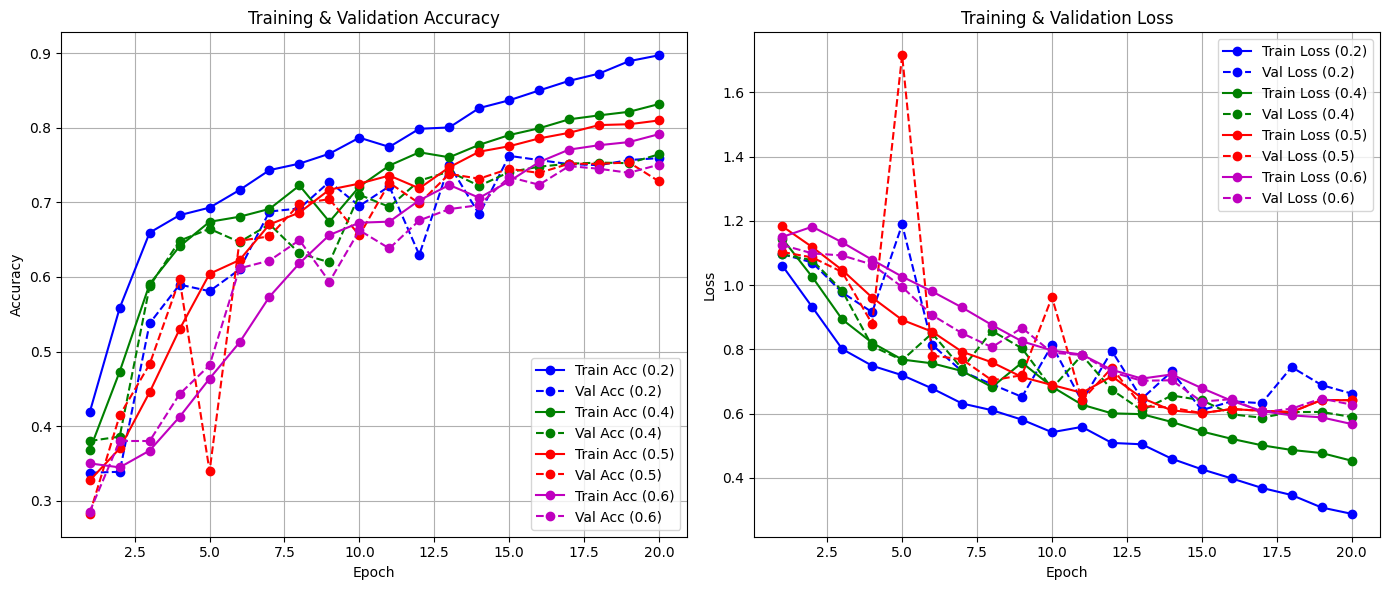

In [19]:
import matplotlib.pyplot as plt

#These values were compiled from the values printed before and in the other jupyter notebook.
# Validation values are from the odd-indexed lines and training from the even-indexed lines.
val_acc_02   = [0.3375, 0.3387, 0.5378, 0.5897, 0.5809, 0.6100, 0.6877, 0.6918, 0.7275, 0.6952,
                0.7215, 0.6296, 0.7503, 0.6839, 0.7623, 0.7567, 0.7512, 0.7499, 0.7567, 0.7593]
val_loss_02  = [1.0966, 1.0704, 0.9772, 0.9158, 1.1888, 0.8148, 0.7316, 0.6915, 0.6524, 0.8128,
                0.6391, 0.7953, 0.6466, 0.7314, 0.6111, 0.6387, 0.6327, 0.7452, 0.6892, 0.6628]

train_acc_02 = [0.4186, 0.5584, 0.6594, 0.6828, 0.6929, 0.7165, 0.7432, 0.7519, 0.7652, 0.7867,
                0.7743, 0.7986, 0.8004, 0.8264, 0.8368, 0.8500, 0.8629, 0.8726, 0.8893, 0.8972]
train_loss_02 = [1.0608, 0.9317, 0.8012, 0.7492, 0.7199, 0.6787, 0.6318, 0.6109, 0.5815, 0.5424,
                 0.5590, 0.5091, 0.5049, 0.4599, 0.4271, 0.3987, 0.3693, 0.3470, 0.3082, 0.2886]


# Validation metrics
val_acc_04 = [0.3800, 0.3859, 0.5876, 0.6486, 0.6645,0.6467, 0.6707, 0.6316, 0.6196, 0.7102,
    0.6939, 0.7290, 0.7413, 0.7221, 0.7405,0.7478, 0.7518, 0.7533, 0.7525, 0.7644]

val_loss_04 = [1.0957, 1.0778, 0.9825, 0.8102, 0.7667,0.8501, 0.7401, 0.8579, 0.8033, 0.6790,
    0.7822, 0.6744, 0.6105, 0.6566, 0.6421,0.5982, 0.5876, 0.6051, 0.6055, 0.5899]

# Training metrics
train_acc_04 = [0.3679, 0.4731, 0.5905, 0.6410, 0.6739,0.6807, 0.6912, 0.7226, 0.6740, 0.7211,
    0.7493, 0.7671, 0.7604, 0.7771, 0.7902,0.7993, 0.8113, 0.8166, 0.8214, 0.8318]

train_loss_04 = [
    1.1450, 1.0255, 0.8933, 0.8208, 0.7686,0.7568, 0.7329, 0.6830, 0.7591, 0.6842,
    0.6281, 0.6012, 0.5987, 0.5744, 0.5448,0.5218, 0.5019, 0.4872, 0.4777, 0.4539
]


train_acc_05 = [0.3271, 0.3700, 0.4455, 0.5299, 0.6042, 0.6226, 0.6704, 0.6863, 0.7170, 0.7251,
                0.7359, 0.7188, 0.7470, 0.7679, 0.7752, 0.7857, 0.7932, 0.8036, 0.8047, 0.8098]
val_acc_05   = [0.2824, 0.4143, 0.4831, 0.5967, 0.3394, 0.6484, 0.6544, 0.6978, 0.7044, 0.6557,
                0.7262, 0.6986, 0.7381, 0.7317, 0.7450, 0.7394, 0.7518, 0.7516, 0.7535, 0.7281]

train_loss_05 = [1.1832, 1.1185, 1.0470, 0.9615, 0.8920, 0.8554, 0.7929, 0.7599, 0.7141, 0.6894,
                 0.6652, 0.7165, 0.6489, 0.6103, 0.6017, 0.6146, 0.6090, 0.6051, 0.6427, 0.6420]
val_loss_05   = [1.1032, 1.0863, 1.0408, 0.8792, 1.7154, 0.7809, 0.7692, 0.7038, 0.7200, 0.9626,
                 0.6418, 0.7427, 0.6235, 0.6190, 0.6017, 0.6146, 0.6090, 0.6051, 0.6427, 0.6420]

train_acc_06 = [0.3500, 0.3446, 0.3672, 0.4124, 0.4637, 0.5122, 0.5735, 0.6183, 0.6562, 0.6727, 0.6741,
                0.7027, 0.7233, 0.7061, 0.7281, 0.7540, 0.7707, 0.7766, 0.7808, 0.7914]

val_acc_06   = [0.2852, 0.3800, 0.3800, 0.4430, 0.4816, 0.6115, 0.6219, 0.6493, 0.5936, 0.6625, 0.6382,
                0.6758, 0.6909, 0.6963, 0.7339, 0.7236, 0.7486, 0.7450, 0.7396, 0.7505]

train_loss_06 = [1.1500, 1.1819, 1.1331, 1.0789, 1.0265, 0.9805, 0.9306, 0.8759, 0.8253, 0.7969, 0.7840,
                 0.7367, 0.7093, 0.7222, 0.6797, 0.6402, 0.6082, 0.5949, 0.5887, 0.5680]

val_loss_06   = [1.1249,1.0990, 1.0924, 1.0641, 0.9944, 0.9068, 0.8505, 0.8069, 0.8675, 0.7900, 0.7827,
                 0.7294, 0.7026, 0.7041, 0.6375, 0.6455, 0.6047, 0.6157, 0.6473, 0.6283]



# Epochs for each dropout rate (based on list lengths)
epochs_02 = list(range(1, len(val_acc_02) + 1))
epochs_04 = list(range(1, len(val_acc_04) + 1))
epochs_05 = list(range(1, len(val_acc_05) + 1))
epochs_06 = list(range(1, len(val_acc_06) + 1))

plt.figure(figsize=(14, 6))

# ---------------------------
# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(epochs_02, train_acc_02, 'b-o', label='Train Acc (0.2)')
plt.plot(epochs_02, val_acc_02, 'b--o', label='Val Acc (0.2)')

plt.plot(epochs_04, train_acc_04, 'g-o', label='Train Acc (0.4)')
plt.plot(epochs_04, val_acc_04, 'g--o', label='Val Acc (0.4)')

plt.plot(epochs_05, train_acc_05, 'r-o', label='Train Acc (0.5)')
plt.plot(epochs_05, val_acc_05, 'r--o', label='Val Acc (0.5)')

plt.plot(epochs_06, train_acc_06, 'm-o', label='Train Acc (0.6)')
plt.plot(epochs_06, val_acc_06, 'm--o', label='Val Acc (0.6)')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid(True)

# ---------------------------
# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(epochs_02, train_loss_02, 'b-o', label='Train Loss (0.2)')
plt.plot(epochs_02, val_loss_02, 'b--o', label='Val Loss (0.2)')

plt.plot(epochs_04, train_loss_04, 'g-o', label='Train Loss (0.4)')
plt.plot(epochs_04, val_loss_04, 'g--o', label='Val Loss (0.4)')

plt.plot(epochs_05, train_loss_05, 'r-o', label='Train Loss (0.5)')
plt.plot(epochs_05, val_loss_05, 'r--o', label='Val Loss (0.5)')

plt.plot(epochs_06, train_loss_06, 'm-o', label='Train Loss (0.6)')
plt.plot(epochs_06, val_loss_06, 'm--o', label='Val Loss (0.6)')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()